# Factors influencing stroke
Analysis on Kaggle dataset (https://www.kaggle.com/asaumya/healthcare-dataset-stroke-data), to build a simple predictor for stroke occurrence.

## Contents of this notebook
- packages and data import;
- Data exploration;
- Data preprocessing;
- Building the predictive model;
- Hyperparameter tuning, model performance and feature importance;
- Analysis on the data without _"somking_status"_ feature.

_TO DO:_  
- _smoking status: fill values and make dummy variable for missing value_ DONE
- _separate/modularise/comment notebook_
- _make some visualisation for the readme_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import roc_curve,classification_report,confusion_matrix,ConfusionMatrixDisplay,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,auc,roc_auc_score,precision_score,recall_score

In [2]:
train_df = pd.read_csv('train_2v.csv')

In [3]:
train_df.shape

(43400, 12)

In [5]:
train_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


The dataset contains a mix of numerical and categorical variables. Depending on the model that I want to use, I can follow different strategies to deal with the categorical data:
- Encoding: substituting labels with cardinal numbers, so for instance (yes,no) with (1,0);
- Dummies: create a boolean variable for each value of a given variable, so for example _Residence_type_ would be split in 2 variables, _Rural_ and _Urban_.

## Data Exploration

In [6]:
train_df['gender'].value_counts()

Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

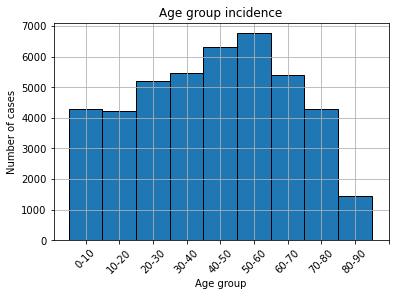

In [10]:
bins_edges = np.arange(0,100,10)
bin_labels=[str(bins_edges[i])+'-'+str(bins_edges[i+1]) for i in range(len(bins_edges)-1)]
train_df.hist('age',bins=bins_edges,ec='black')
plt.xticks(np.arange(5,105,10),labels=bin_labels,rotation=45)
plt.title('Age group incidence')
plt.xlabel('Age group')
plt.ylabel('Number of cases')
plt.savefig('images/Age_hist.png',bbox_inches='tight')

In [8]:
train_df['hypertension'].value_counts()

0    39339
1     4061
Name: hypertension, dtype: int64

In [9]:
train_df['heart_disease'].value_counts()

0    41338
1     2062
Name: heart_disease, dtype: int64

In [10]:
train_df['ever_married'].value_counts()

Yes    27938
No     15462
Name: ever_married, dtype: int64

In [11]:
train_df['Residence_type'].value_counts()

Urban    21756
Rural    21644
Name: Residence_type, dtype: int64

In [12]:
train_df['work_type'].value_counts()

Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: work_type, dtype: int64

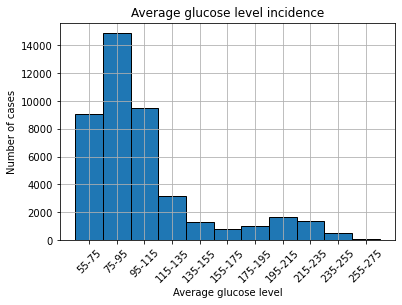

In [12]:
bins_width = 20
bins_edges = np.arange(min(train_df['avg_glucose_level']),max(train_df['avg_glucose_level'])+1,bins_width)
bin_labels=[str(int(bins_edges[i]))+'-'+str(int(bins_edges[i+1])) for i in range(len(bins_edges)-1)]
train_df.hist('avg_glucose_level',bins =bins_edges, ec='black')
plt.xticks(np.arange(min(train_df['avg_glucose_level'])+bins_width/2,max(train_df['avg_glucose_level'])-+bins_width/2,bins_width),labels=bin_labels,rotation=45)
plt.title('Average glucose level incidence')
plt.xlabel('Average glucose level')
plt.ylabel('Number of cases')
plt.savefig('images/Avg_glucose_hist.png',bbox_inches='tight')

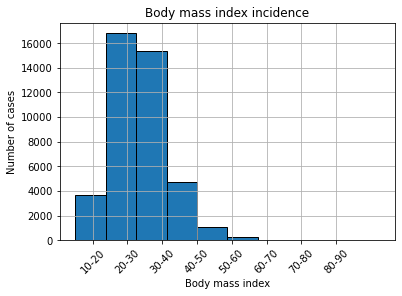

In [8]:
bins_width = 10
bins_edges = np.arange(min(train_df['bmi']),max(train_df['bmi'])+1,bins_width)
bin_labels=[str(int(bins_edges[i]))+'-'+str(int(bins_edges[i+1])) for i in range(len(bins_edges)-1)]
train_df.hist('bmi',ec='black')
plt.xticks(np.arange(min(train_df['bmi'])+bins_width/2,max(train_df['bmi'])-+bins_width/2,bins_width),labels=bin_labels,rotation=45)
plt.xlabel('Body mass index')
plt.ylabel('Number of cases')
plt.title('Body mass index incidence')
plt.savefig('images/BMI_hist.png',bbox_inches='tight')

In [11]:
train_df['smoking_status'].value_counts()

never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64

In [44]:
train_df['stroke'].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

In [131]:
len(train_df[train_df['stroke']==1])/train_df.shape[0]

0.01804147465437788

The data is inbalanced, and a predictor will likely fail in predicting any storke occurrence if we do not balance it. I could balance the data through undersampling, but I would probably lose a lot of information.

##  Preprocessing - Making the final training data set
### Dealing with null values

In [42]:
train_df.columns[train_df.isnull().any()].tolist()

['bmi', 'smoking_status']

In [121]:
train_df['bmi'].isnull().sum()/len(train_df['bmi'])

0.03368663594470046

In [45]:
train_df['smoking_status'].isnull().sum()/len(train_df['smoking_status'])

0.3062672811059908

For BMI, I am going to fill the missing values with the average value.

Roughly 30% of the _'smoking_status'_ column has a null value, and substitute it with any value is risky as it could include a systematic error. In order to take into account the fact the information was making, I am making a dummy variable _missing_smoking_status_, with values (0,1).

In [23]:
train_feat = train_df.copy()
train_feat = train_feat.drop('id',axis=1)
train_feat['bmi'] = train_feat['bmi'].fillna(train_feat['bmi'].mean())

# creating dummy column for smoking status missing value
train_feat['missing_smoking_status'] = np.where(train_feat['smoking_status'].isnull(), 1, 0)
train_feat['smoking_status']= train_feat['smoking_status'].fillna('never smoked')

# re-ordering columns
train_feat = train_feat[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'missing_smoking_status', 'stroke']]

In [24]:
train_feat['missing_smoking_status'].value_counts()

0    30108
1    13292
Name: missing_smoking_status, dtype: int64

In [25]:
train_feat.shape

(43400, 12)

In [26]:
train_feat.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,missing_smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,never smoked,1,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,never smoked,1,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,never smoked,1,0


### Encoding non-numerical variables

In [27]:
categorical_cols =['gender','ever_married','work_type','Residence_type','smoking_status']
for col in categorical_cols:
    enc = LabelEncoder()
    enc.fit(train_feat[col])
    train_feat[col]=enc.transform(train_feat[col])
    
train_feat.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,missing_smoking_status,stroke
0,1,3.0,0,0,0,4,0,95.12,18.0,1,1,0
1,1,58.0,1,0,1,2,1,87.96,39.2,1,0,0
2,0,8.0,0,0,0,2,1,110.89,17.6,1,1,0
3,0,70.0,0,0,1,2,0,69.04,35.9,0,0,0
4,1,14.0,0,0,0,1,0,161.28,19.1,1,1,0


### Balancing the data through over-sampling

I am going to use the Synthetic Minority Oversampling Technique (SMOTE), which generates synthetic members of the minority class, in such a wy that their nearest neighbours are of the same class. Over sampling can lead to over fitting, as it is based on a data distribution already present within data and not necessarily generalisable.

I have decided to use a random forest classifier, as it can handle categorical data well.

In [29]:
X_train_feat = train_feat.drop('stroke',axis=1)
y_train_feat = train_feat['stroke']

In [30]:
sm = SMOTENC(categorical_features=[0,2,3,4,5,6,9])
X_res,y_res = sm.fit_resample(X_train_feat,y_train_feat)

In [31]:
X_res.shape

(85234, 11)

In [167]:
y_res.value_counts()

1    29470
0    29470
Name: stroke, dtype: int64

## Building the predictive model

In [32]:
X_res_train,X_res_test,y_res_train,y_res_test = train_test_split(X_res,y_res,test_size=0.25)

In [33]:
rfc_un = RandomForestClassifier(max_depth=8)
rfc_un.fit(X_res_train,y_res_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
y_pred_un =rfc_un.predict(X_res_test) 
print(classification_report(y_res_test,y_pred_un))
print(confusion_matrix(y_res_test,y_pred_un))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84     10776
           1       0.81      0.91      0.85     10533

    accuracy                           0.85     21309
   macro avg       0.85      0.85      0.85     21309
weighted avg       0.85      0.85      0.85     21309

[[8481 2295]
 [ 973 9560]]


In [35]:
f1_score(y_res_test,y_pred_un)

0.8540289440771842

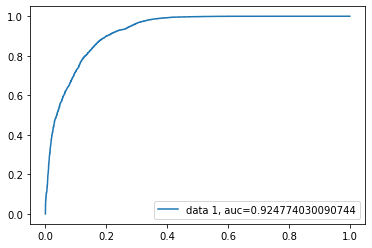

In [37]:
y_pred_prob = rfc_un.predict_proba(X_res_test)[::,1]
roc_curve(y_res_test,y_pred_prob)
false_pos_rate, true_pos_rate, _ = roc_curve(y_res_test,y_pred_prob)
auc = roc_auc_score(y_res_test,y_pred_prob)
plt.plot(false_pos_rate, true_pos_rate,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [41]:
useful_features =  pd.DataFrame(rfc_un.feature_importances_,columns=['Feature Importance'],index=X_train_feat.columns)
useful_features.sort_values(by='Feature Importance',ascending = False)

,Feature Importance
age,0.472231
ever_married,0.182016
avg_glucose_level,0.084514
work_type,0.079828
missing_smoking_status,0.079320
bmi,0.054275
smoking_status,0.020189
Residence_type,0.008484
hypertension,0.008112
gender,0.007488


## Optimising the model - Hyperparameter tuning

In [44]:
rfc = RandomForestClassifier(max_depth=14)
#param = {'ccp_alpha':[0.0,0.01], 'n_estimators':[50,75,100,125], 'max_features':np.arange(2,6,1)}
#param = {'n_estimators':[50,75,100,125], 'max_features':np.arange(2,6,1),'max_depth':np.arange(6,20,1)}
param = {'max_features':np.arange(2,11,1)}
clf = GridSearchCV(rfc,param,scoring='roc_auc',refit=True,cv=10)
clf.fit(X_res_train,y_res_train)
print('Best roc_auc: {:.4}, with best Parameters: {}'.format(clf.best_score_, clf.best_params_))


Best roc_auc: 0.9844, with best Parameters: {'max_features': 10}


first run: Best roc_auc: 0.9742, with best Parameters: {'criterion': 'gini', 'max_depth': 14, 'min_samples_split': 2}

sec run: Best roc_auc: 0.9804, with best Parameters: {'max_features': 5, 'n_estimators': 125}

third run : Best roc_auc: 0.9923, with best Parameters: {'max_depth': 19}

In [45]:
#rfc = RandomForestClassifier(max_features= 5, n_estimators= 125, max_depth=19,min_samples_split= 2)
rfc = RandomForestClassifier(min_samples_split= 2)
rfc.fit(X_res_train,y_res_train)
y_pred =rfc.predict(X_res_test) 
print(classification_report(y_res_test,y_pred))
print(confusion_matrix(y_res_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10776
           1       0.96      0.98      0.97     10533

    accuracy                           0.97     21309
   macro avg       0.97      0.97      0.97     21309
weighted avg       0.97      0.97      0.97     21309

[[10332   444]
 [  200 10333]]


In [48]:
rfc

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

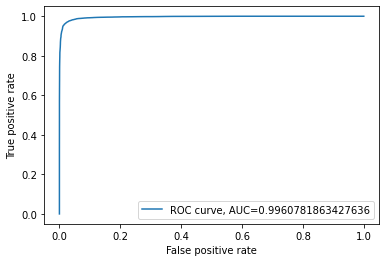

In [46]:
y_pred_prob = rfc.predict_proba(X_res_test)[::,1]
#roc_curve(y_res_test,y_pred_prob)
false_pos_rate, true_pos_rate, _ = roc_curve(y_res_test,y_pred_prob)
auc = roc_auc_score(y_res_test,y_pred_prob)
plt.plot(false_pos_rate, true_pos_rate,label="ROC curve, AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.savefig('roc_curve.png')
plt.show()


In [47]:
useful_features =  pd.DataFrame(rfc.feature_importances_,columns=['Feature Importance'],index=X_train_feat.columns)
useful_features.sort_values(by='Feature Importance',ascending = False)

,Feature Importance
age,0.386340
avg_glucose_level,0.193029
bmi,0.133780
ever_married,0.088285
work_type,0.055685
missing_smoking_status,0.040249
smoking_status,0.033349
Residence_type,0.022581
gender,0.022081
hypertension,0.015527
